# Introduction

<b style="color: red">To use this notebook, go to Runtime > Change Runtime Type and select GPU as the hardware accelerator.</b>

This is code to accompany my blog post building on Kenneth Li et al's paper Emergent World Representations. I found that the network actually learns a **linear** world model, but in terms of whether a cell contains a piece of **my colour** vs the **opponent's colour**. I demonstrate how to use and intervene with the linear probe I found, use the probe to start interpreting the model and studying circuits, and some starter code for neuron interpretability and activation patching

If you're new to mechanistic interpretability, check out [my blog post on getting started](https://neelnanda.io/getting-started). This notebook heavily uses my TransformerLens library, check out [the main tutorial for a better introduction](https://neelnanda.io/transformer-lens-demo).

Read the blog post here: https://neelnanda.io/othello

Look up unfamiliar terms here: https://neelnanda.io/glossary 

The paper: https://arxiv.org/pdf/2210.13382.pdf



## Setup (Don't Read This)

In [2]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install transformer_lens==1.2.1
    %pip install git+https://github.com/neelnanda-io/neel-plotly
    
    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Jupyter notebook - intended for development only!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_123612/347264739.py:21: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_123612/347264739.py:22: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [3]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [4]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [5]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [6]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [7]:
from neel_plotly import line, scatter, imshow, histogram

# Othello GPT

<details><summary>I was in a massive rush when I made this codebase, so it's a bit of a mess, sorry! This Colab is an attempt to put a smiley face on the underlying shoggoth, but if you want more of the guts, here's an info dump</summary>

This codebase is a bit of a mess! This colab is an attempt to be a pretty mask on top of the shoggoth, but if it helps, here's an info dump I wrote for someone about interpreting this codebase:

Technical details:

-   Games are 60 moves, but the model can only take in 59. It's trained to predict the next move, so they give it the first 59 moves (0<=...<59) and evaluate the predictions for each next move (1<=...<60). There is no Beginning of Sequence token, and the model never tries to predict the first move of the game

-   This means that, while in Othello black plays first, here white plays "first" because first is actually second

-   You can get code to load the synthetic model (ie trained to play uniformly random legal moves) into TransformerLens here: [https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Othello\_GPT.ipynb](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Othello_GPT.ipynb) 
-   You can load in their synthetically generated games [from their Github](https://github.com/likenneth/othello_world) (there's a google drive link)
-   Their model has 8 layers, residual stream width 512, 8 heads per layer and 2048 neurons per layer.

-   The vocab size is 61. 0 is -100, which I *think *means pass, I just filtered out the rare games that include that move and ignore it. 1 to 60 (inclusive) means the board moves in lexicographic order (A0, A1, ..., A7, B0, ...) but *skipping *D3, D4, E3 and E4. These are at the center of the board and so can never be played, because Othello starts with them filled)

-   There's 3 ways to denote a board cell. I call them "int", "string" and "label" (which is terrible notation, sorry). 

-   "label" means the label for a board cell, \["A0", ..., "A7", ''', "H7"\] (I index at 0 not 1, sorry!). 
-   "int" means "part of the model vocabulary", so 1 means A0, we then count up but miss the center squares, so 27 is D2, 28 is D5, 33 is E2 and 34 is E5. 
-   "string" means "the input format of the OthelloBoardState class". These are integers (sorry!) from 0 to 63, and exactly correspond to labels A0, ..., H7, without skipping any center cells. OthelloBoardState is a class in data/othello.py that can play the Othello game and tell you the board state and valid moves (created by the authors, not me)
-   I have utility functions to\_int, to\_string, str\_to\_label and int\_to\_label in tl\_othello\_utils.py to do this

-   The embedding and unembedding are untied (ie, in contrast to most language models, the map W\_U from final residual to the logits is *not *the transpose of W\_E, the map from tokens to the initial residual. They're unrelated matrices)
-   tl\_othello\_utils.py is my utils file, with various functions to load games, etc. \`board\_seqs\_string\` and \`board\_seqs\_int\` are massive saved tensors with every move across all 4.5M synthetic games in both string and int format, these are 2.3GB so I haven't attached them lol. You can recreate them from the synthetic games they provide. It also provides a bunch of plotting functions to make nice othello board states, and some random other utilities
-   \`tl\_probing.py\` is my probe training file. But it was used to train a *second* probe, linear\_probe\_L4\_blank\_vs\_color\_v1.pth . This probe actually didn't work very well for analysing the model (despite getting great accuracy) and I don't know why - it was trained on layer 4, to do a binary classification on blank vs not blank, and on my color vs their color *conditional *on not being blank (ie not evaluated if blank). For some reason, the "this cell is my color" direction has a significant dot product with the "is blank" direction, and this makes it much worse for eg interpreting neurons. I don't know why!
-   \`tl\_scratch.py\` is where I did some initial exploration, including activation patching between different final moves
-   \`tl\_exploration.py\` is where I did my most recent exploration, verifying that the probe works, doing probe interventions (CTRL F for \`newly\_legal\`) and using the probe to interpret neurons

</details>


## Loading the model

This loads a conversion of the author's synthetic model checkpoint to TransformerLens format. See [this notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Othello_GPT.ipynb) for how.

In [8]:
import transformer_lens.utils as utils
cfg = HookedTransformerConfig(
    n_layers = 8,
    d_model = 512,
    d_head = 64,
    n_heads = 8,
    d_mlp = 2048,
    d_vocab = 61,
    n_ctx = 59,
    act_fn="gelu",
    normalization_type="LNPre"
)
model = HookedTransformer(cfg)

In [115]:

# sd = utils.download_file_from_hf("NeelNanda/Othello-GPT-Transformer-Lens", "synthetic_model.pth")
champion_ship_sd = utils.download_file_from_hf("NeelNanda/Othello-GPT-Transformer-Lens", "championship_model.pth")
model.load_state_dict(champion_ship_sd)

<All keys matched successfully>

Code to load and convert one of the author's checkpoints to TransformerLens:

Testing code for the synthetic checkpoint giving the correct outputs

# An example input
sample_input = torch.tensor([[20, 19, 18, 10, 2, 1, 27, 3, 41, 42, 34, 12, 4, 40, 11, 29, 43, 13, 48, 56, 33, 39, 22, 44, 24, 5, 46, 6, 32, 36, 51, 58, 52, 60, 21, 53, 26, 31, 37, 9, 25, 38, 23, 50, 45, 17, 47, 28, 35, 30, 54, 16, 59, 49, 57, 14, 15, 55, 7]])
# The argmax of the output (ie the most likely next move from each position)
sample_output = torch.tensor([[21, 41, 40, 34, 40, 41,  3, 11, 21, 43, 40, 21, 28, 50, 33, 50, 33,  5,
         33,  5, 52, 46, 14, 46, 14, 47, 38, 57, 36, 50, 38, 15, 28, 26, 28, 59,
         50, 28, 14, 28, 28, 28, 28, 45, 28, 35, 15, 14, 30, 59, 49, 59, 15, 15,
         14, 15,  8,  7,  8]])


model(sample_input).argmax(dim=-1)

## Loading Othello Content
Boring setup code to load in 100K sample Othello games, the linear probe, and some utility functions

In [10]:
import sys
sys.path.append("/home/jsetpal/othello_world/mechanistic_interpretability")
from mech_interp_othello_utils import plot_single_board, to_string, to_int, int_to_label, string_to_label, OthelloBoardState

We load in a big tensor of 100,000 games, each with 60 moves. This is in the format the model wants, with 1-59 representing the 60 moves, and 0 representing pass.

We also load in the same set of games, in the same order, but in "string" format - still a tensor of ints but referring to moves with numbers from 0 to 63 rather than in the model's compressed format of 1 to 59

In [11]:
OTHELLO_ROOT = Path("/home/jsetpal/othello_world/")

In [12]:
from mechanistic_interpretability.data import ContrastiveDataset

In [13]:
ds = ContrastiveDataset()

In [149]:
board_seqs_int = torch.tensor(np.load(OTHELLO_ROOT/"mechanistic_interpretability/board_seqs_int_small.npy"), dtype=torch.long) # ds.as_seqs_int() # 
board_seqs_string = torch.tensor(np.load(OTHELLO_ROOT/"mechanistic_interpretability/board_seqs_string_small.npy"), dtype=torch.long) # ds.as_seqs_str() 

num_games, length_of_game = board_seqs_int.shape
print("Number of games:", num_games,)
print("Length of game:", length_of_game)

Number of games: 100000
Length of game: 60


In [15]:
board_seqs_int.max()

tensor(60)

In [16]:
board_seqs_string.max()

tensor(63)

In [17]:
stoi_indices = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
]
alpha = "ABCDEFGH"


def to_board_label(i):
    return f"{alpha[i//8]}{i%8}"


board_labels = list(map(to_board_label, stoi_indices))

In [18]:
to_board_label(63)

'H7'

In [19]:
for i in range(63):
    if i not in stoi_indices:
        print(i)

27
28
35
36


## Running the Model

The model's context length is 59, not 60, because it's trained to receive the first 59 moves and predict the final 59 moves (ie `[0:-1]` and `[1:]`. Let's run the model on the first 30 moves of game 0!

In [128]:
def mean_score(moves_int, logits, ret_list=True):
    discount = 0
    aggregate = []
    for idx in range(moves_int.shape[0]):
        board = OthelloBoardState()
        board.update(to_string(moves_int[idx]))
    
        logit_vec = logits[idx, -1]
        log_probs = logit_vec.log_softmax(-1)
        # Remove passing
        log_probs = log_probs[1:]
        assert len(log_probs)==60
        
        temp_board_state = torch.zeros(64, device=logit_vec.device)
        temp_board_state -= 15.
        temp_board_state[stoi_indices] = log_probs
    
        score = board.score(temp_board_state)
        if score is not None: aggregate.append(score)
        else: discount += 1
    print(f'{discount} illegal moves')
    if ret_list: return aggregate
    return sum(aggregate) / (moves_int.shape[0] - discount)
        

In [21]:
moves_int = board_seqs_int[:400, :30]

logits = model(moves_int)
print("logits:", logits.shape)
ret2 = mean_score(moves_int, logits)

logits: torch.Size([400, 30, 61])
32 illegal moves


In [22]:
# plt.clf()
# plt.hist(ret0, histtype=u'step')
# plt.hist(ret1, histtype=u'step')
# plt.hist(ret2, histtype=u'step')
# plt.savefig('woc.png')

In [23]:
moves_int = board_seqs_int[-400:, :30]

logits = model(moves_int)
print("logits:", logits.shape)
mean_score(moves_int, logits)

logits: torch.Size([400, 30, 61])
38 illegal moves


[-6,
 -1,
 -6,
 -6,
 2,
 -4,
 3,
 2,
 0,
 -8,
 3,
 5,
 0,
 0,
 -2,
 -1,
 -8,
 2,
 0,
 3,
 -2,
 0,
 2,
 -1,
 -5,
 -2,
 -4,
 4,
 -1,
 -4,
 8,
 -2,
 0,
 0,
 4,
 2,
 3,
 -2,
 1,
 1,
 0,
 0,
 0,
 -4,
 8,
 -10,
 0,
 5,
 -1,
 8,
 9,
 -1,
 8,
 -1,
 -6,
 -1,
 3,
 -1,
 2,
 1,
 -3,
 -1,
 3,
 3,
 -8,
 -8,
 5,
 -2,
 -1,
 -1,
 0,
 -8,
 -6,
 -3,
 1,
 8,
 3,
 1,
 0,
 -3,
 3,
 5,
 -2,
 -7,
 -3,
 4,
 -5,
 -2,
 8,
 3,
 1,
 8,
 -2,
 -5,
 -7,
 -1,
 9,
 -4,
 8,
 -3,
 -4,
 -3,
 7,
 -1,
 2,
 4,
 -11,
 8,
 3,
 1,
 -1,
 0,
 3,
 0,
 2,
 7,
 4,
 0,
 0,
 4,
 0,
 1,
 0,
 4,
 0,
 -1,
 -3,
 4,
 1,
 0,
 1,
 5,
 -7,
 -3,
 -3,
 -4,
 -5,
 -2,
 -6,
 3,
 9,
 5,
 0,
 4,
 -2,
 2,
 0,
 -1,
 2,
 8,
 9,
 4,
 5,
 -1,
 4,
 -1,
 7,
 -3,
 -4,
 0,
 5,
 -3,
 0,
 -4,
 -1,
 8,
 -3,
 -6,
 0,
 5,
 -1,
 -2,
 -6,
 0,
 -12,
 3,
 -4,
 -8,
 9,
 -2,
 0,
 -6,
 0,
 9,
 -3,
 -2,
 5,
 3,
 12,
 2,
 1,
 -1,
 -1,
 -2,
 0,
 7,
 1,
 1,
 -4,
 -3,
 1,
 11,
 1,
 -2,
 1,
 1,
 7,
 5,
 -3,
 11,
 -2,
 1,
 0,
 8,
 0,
 0,
 -1,
 0,
 3,
 4,
 -1,
 3,
 2,
 1,
 -4,


In [24]:
logits[0, -1].log_softmax(-1)[1:]

tensor([-26.7173, -14.3825, -22.8553, -20.7587, -17.2164, -22.0967, -17.6001,
        -16.1091, -17.9181, -16.6107, -17.6684, -16.2971, -18.9724, -17.0783,
        -26.3339, -19.7350, -19.5273, -22.6599, -27.1381, -19.7453, -24.4807,
        -19.1345, -23.3022, -15.9375, -27.6966,  -9.5688, -19.8827, -15.9409,
        -19.2781, -21.6208, -12.9044, -24.7155, -26.5700, -17.6436, -17.6094,
         -8.6965, -11.0773, -17.1337, -25.2136, -16.0457, -14.1063, -20.0750,
        -11.9031, -22.3970,  -6.1723,  -5.6357,  -0.1796, -18.2915, -26.9880,
        -12.3782, -10.8979, -18.3127, -21.9537,  -9.2534, -19.7104, -21.3561,
         -7.6239,  -2.5419,  -2.5366, -12.9368], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [25]:
logits.shape

torch.Size([400, 30, 61])

In [26]:
logits[0, -1].argmax().item()

47

We take the final vector of logits. We convert it to log probs and we then remove the first element (corresponding to passing, and we've filtered out all games with passing) and get the 60 logits. This is 64-4 because the model's vocab is compressed, since the center 4 squares can't be played.

We then convert it to an 8 x 8 grid and plot it, with some tensor magic

In [27]:
logit_vec = logits[0, -1]
log_probs = logit_vec.log_softmax(-1)
# Remove passing
log_probs = log_probs[1:]
assert len(log_probs)==60

temp_board_state = torch.zeros(64, device=logit_vec.device)
# Set all cells to -15 by default, for a very negative log prob - this means the middle cells don't show up as mattering
temp_board_state -= 15.
temp_board_state[stoi_indices] = log_probs

We can now plot this as a board state! We see a crisp distinction from a set of moves that the model clearly thinks are valid (at near uniform probabilities), and a bunch that aren't. Note that by training the model to predict a *uniformly* chosen next move, we incentivise it to be careful about making all valid logits be uniform!

In [28]:
def plot_square_as_board(state, diverging_scale=True, **kwargs):
    """Takes a square input (8 by 8) and plot it as a board. Can do a stack of boards via facet_col=0"""
    if diverging_scale:
        imshow(state, y=[i for i in alpha], x=[str(i) for i in range(8)], color_continuous_scale="RdBu", color_continuous_midpoint=0., aspect="equal", **kwargs)
    else:
        imshow(state, y=[i for i in alpha], x=[str(i) for i in range(8)], color_continuous_scale="Blues", color_continuous_midpoint=None, aspect="equal", **kwargs)
plot_square_as_board(temp_board_state.reshape(8, 8), zmax=0, diverging_scale=False, title="Example Log Probs")

In [29]:
from mechanistic_interpretability.tl_probing_v1 import seq_to_state_stack, state_stack_to_one_hot

In [31]:
from torch.utils.data import DataLoader

In [62]:
epochs = 100
layer = 6
batch_size = 256
lr = 1e-4
wd = 0.01
pos_start = 5
pos_end = model.cfg.n_ctx - 5
length = pos_end - pos_start

linear_probe = torch.randn(
    model.cfg.d_model, 2, requires_grad=False, device="cuda"
)/np.sqrt(model.cfg.d_model)
linear_probe.requires_grad = True
optimizer = torch.optim.AdamW([linear_probe], lr=lr, betas=(0.9, 0.99), weight_decay=wd)
loss_fn = torch.nn.CrossEntropyLoss()
softmax = torch.nn.Softmax(dim=-1)

for epoch in range(epochs):
    for games_str, y in DataLoader(ds, shuffle=True, batch_size=batch_size):
        games_int = ds.as_seqs_int(games_str.detach().clone())

        state_stack = torch.stack(
            [torch.tensor(seq_to_state_stack(game)) for game in games_str]
        )
        state_stack = state_stack[:, pos_start:pos_end, :, :]
        state_stack_one_hot = state_stack_to_one_hot(state_stack).cuda()
        
        with torch.inference_mode():
            _, cache = model.run_with_cache(games_int.cuda()[:, :-1], return_type=None)
            resid_post = cache["resid_post", layer][:, pos_start:pos_end]
        probe_out = einsum("batch pos d_model, d_model pred -> batch pred", resid_post, linear_probe)

        # probe_correct_log_probs = einops.reduce(
        #     probe_out.log_softmax(0) * state_stack_one_hot,
        #     "batch pos pred -> batch pred",
        #     "mean"
        # ) * probe_out.shape[1]
        
        # loss = loss_fn(y.cuda(), torch.e**probe_correct_log_probs)
        loss = loss_fn(y.cuda(), probe_out.softmax(dim=-1))
        print(loss)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()    

tensor(1.0140, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0310, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0225, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9979, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0166, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0117, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9916, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0224, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9855, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0365, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9753, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9273, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0119, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9214, device='cuda:0', grad_fn=<DivBackward1>)
tensor(1.0101, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9647, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9670, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9852, device='cuda:0', grad_fn=<DivBack

In [64]:
torch.save(linear_probe, 'skill_probe.pt')

In [68]:
skill_intervention_vector = linear_probe[:, 0] - linear_probe[:, 1]

In [71]:
skill_intervention_vector

tensor([ 5.7978e-02,  1.1068e-01,  2.3116e-02,  8.1939e-02, -5.1484e-02,
         7.9068e-02,  7.8090e-02, -2.7557e-02,  1.0070e-02,  2.0353e-02,
        -3.1920e-02,  5.1530e-02,  4.9452e-02, -3.8679e-03, -2.1139e-02,
         9.1300e-02,  4.4707e-02, -3.0904e-02,  1.1623e-02, -4.2785e-02,
        -8.5112e-02, -1.2063e-02, -2.0106e-02,  1.2375e-02, -4.9349e-02,
         1.5547e-02,  5.5086e-02,  7.2022e-02, -1.1563e-02,  1.4543e-02,
         5.5412e-02, -7.9971e-02,  7.2672e-02, -6.1554e-03, -1.7584e-02,
         1.6050e-01,  1.3123e-02, -1.2831e-02,  2.3952e-02,  5.0120e-02,
         7.9013e-02,  1.4330e-02, -1.2310e-01, -3.5990e-02,  1.4748e-01,
        -7.9505e-02, -6.1255e-02,  8.5031e-02,  1.8951e-02,  4.2056e-02,
        -2.3299e-02, -2.2425e-02,  4.4497e-02,  6.7761e-02,  1.9736e-02,
        -5.9430e-02,  6.3017e-02, -3.5664e-02,  1.2342e-02, -1.0197e-01,
         1.8769e-02, -5.9005e-02, -4.7482e-02, -4.3249e-03, -1.8825e-02,
        -3.7061e-02,  2.0333e-02, -2.5779e-05,  1.7

In [116]:
d = model.blocks[6].mlp.state_dict()

In [117]:
d['b_out'] += skill_intervention_vector

In [118]:
model.blocks[6].mlp.load_state_dict(d)

<All keys matched successfully>

In [122]:
import matplotlib.pyplot as plt

In [150]:
moves_int = board_seqs_int[:400, :30]

logits = model(moves_int)
print("logits:", logits.shape)
ret2 = mean_score(moves_int, logits)

logits: torch.Size([400, 30, 61])
28 illegal moves


In [145]:
mean_score(moves_int, logits, ret_list=False)

30 illegal moves


0.32972972972972975

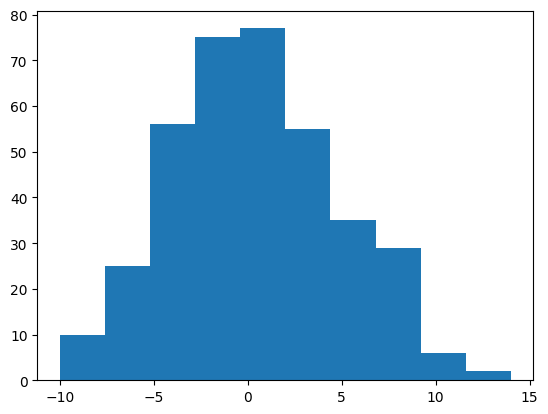

In [146]:
plt.hist(ret0)
plt.savefig('updated_ood.png')

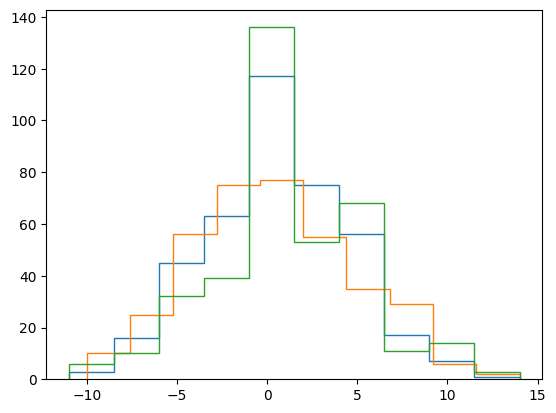

In [151]:
plt.clf()
plt.hist(ret0, histtype=u'step')
plt.hist(ret1, histtype=u'step')
plt.hist(ret2, histtype=u'step')
plt.savefig('updated_cumulative.png')